<a href="https://colab.research.google.com/github/eljimenezj/CM0868--Estadistica-Multivariada-Avanzada/blob/master/Prueba_desempe%C3%B1o_Arqu_CatsvsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadistica Multivariada - Clasificación de imagenes utilizando Machine Learning y Deep Learning

A continuación se presenta un estudio de clasificación de imagenes utilizando un modelo de regresión logística y posteriormente el uso de redes neuronales profundas. Esto libro hace parte del proyecto final del curso de Estadistica Multivariada Avanzanda de la Maestría de Ciencia de Datos.

Los integrantes de este trabajo:

* Jorge Luis Renteria Roa - jlrenteria@eafit.edu.co
* Edgar Leandro Jimenez Jaimes - eljimenezj@eafit.edu.co


Este libro se encuentra organizado de la siguiente manera:

1. Lectura y estructuración del pipeline de los datos.
  * Estructuración del Data Augmentation utilizando `ImageDataGenerator`
2. Construcción y entrenamiento modelo de regresión logistica.
3. Construcción y entrenamiento Red Neuronal Convolucional construida desde cero.
4. Entrenamiento de red neuronal preentrenada:
  * `ResNet50`




In [0]:
# Importación librerias
from PIL import Image
import pandas as pd
import glob
import re
import numpy as np
import imutils
import time
import os  
import seaborn as sn  
import datetime
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
import keras_preprocessing
from keras.applications import densenet  
from keras import regularizers  
from keras import backend as K  
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential  
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report  

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# 1. Lectura y estructuración del pipeline de los datos.

## 1.1 Estructuración del Data Augmentation utilizando ImageDataGenerator

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Definición de algunos parametros de entrada

img_width, img_height = 256, 256   # Tamaño de imagenes  
nb_train_samples = 4000             # Numero inicial de muestras en train
nb_validation_samples = 1000       # Numero inicial de muestras en validation
nb_test_samples = 500
batch_size = 32                    # Numero de imagenes a utilizar para entrenar por epoca


# Directorios de almacenamiento
path_base = '/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_pets'

train_data_dir = path_base + '/Train'  
validation_data_dir = path_base + '/Validation'
test_data_dir = path_base + '/Test'

In [0]:
# Estructuramos el DataAugmentacion para el train, validation y test

# Importacion
imgen = ImageDataGenerator(rescale=1/255)

# Generador Data Augmentacion en Train 
train_datagen = ImageDataGenerator(  
    rescale=1. / 127.5 - 1, #1. / 255,#,                                             # Normalizacion de los pixeles de imagenes
    #width_shift_range=[-100,100],                                # Numero aleatorio entre -200 y 200 y hace el shift () si es > 1 son pixeles, sino es %
    #height_shift_range=0.1,                                      # 
    horizontal_flip=True,                                         #
    rotation_range=90,                                            # Rotaciónn de la imagen en el rango [0,90]
    brightness_range=[0.2,0.8],                                   #
    zoom_range=[0.8,1.2])                                         # Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                              # Directorio de datos de entrenamiento  
    target_size=(img_width, img_height),                         # Dimensiones de las imagenes    
    batch_size=batch_size,                                       # Particiones por imagenes                        
    class_mode='binary')                                         # Tipo de clase de labels

# Lectura de validation

validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 

validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') 

# Lectura de test
test_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') 


Found 8008 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


# 1. Modelo de regresión logística con Keras - TensorFlow

A continuación vamos a construir una regresión logistica como un primer modelo, pero utilizando Keras de TensorFlow. Esto es una red neuronal de una neurona con una función de activación sigmoide:

$$f(x)=\frac{1}{1+e^{-x}}$$

In [0]:
# Construcción de regresión logistica

K.clear_session()
model_1 = Sequential()
model_1.add(Flatten(input_shape=(256,256,3)))      # Entrada de las imagenes, formato y profundidad  
model_1.add(Dense(1))                              # Agregar una neurona  
model_1.add(Activation('sigmoid'))                 # Función de activación sigmoide    

model_1.summary()                                  # Mirar arquitectura del modelo

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 196609    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 196,609
Trainable params: 196,609
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compilamos y ejecutamos
 
model_1.compile(loss='binary_crossentropy',                                                     # Función de perdida 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),                # Cuando se mueva por el loss lo haga mas despacio  
              metrics=[tf.keras.metrics.AUC()])                                        # Metrica a utilizar : AUC               
              #metrics = ['auc'])                           

historia1 = model_1.fit_generator(train_generator,                                    # Generador de datos de train, con data augmentation 
                    epochs=20,                                                        # Numero de epocas (# de veces que se pasa por los datos )  
                    #steps_per_epoch= nb_train_samples // batch_size,                  # Partición de los datos en cada epoca (# numero de imagenes)                          #   
                    validation_data=validation_generator)                             # Datos de validación



Epoch 1/20
251/251 [==============================] - 5243s 21s/step - loss: 60.0978 - auc: 0.5164 - val_loss: 85.8377 - val_auc: 0.5171
Epoch 2/20
251/251 [==============================] - 155s 618ms/step - loss: 46.8997 - auc: 0.5177 - val_loss: 60.7630 - val_auc: 0.5198
Epoch 3/20
251/251 [==============================] - 150s 600ms/step - loss: 44.3069 - auc: 0.5184 - val_loss: 29.3657 - val_auc: 0.5199
Epoch 4/20
251/251 [==============================] - 149s 593ms/step - loss: 41.2900 - auc: 0.5216 - val_loss: 24.1459 - val_auc: 0.5229
Epoch 5/20
251/251 [==============================] - 155s 619ms/step - loss: 36.8130 - auc: 0.5240 - val_loss: 121.8529 - val_auc: 0.5244
Epoch 6/20
251/251 [==============================] - 150s 597ms/step - loss: 40.5862 - auc: 0.5256 - val_loss: 200.6076 - val_auc: 0.5265
Epoch 7/20
251/251 [==============================] - 148s 590ms/step - loss: 43.8238 - auc: 0.5267 - val_loss: 63.3906 - val_auc: 0.5280
Epoch 8/20
251/251 [=============

In [0]:
model_1.evaluate_generator(test_generator)

[165.07623291015625, 0.5316228866577148]

In [0]:
# Guardo el modelo
model_1.save("modelo_regresion")

# Pesos
model_1.save_weights("modelo_regresion_pesos")

### Graficas de desempeño

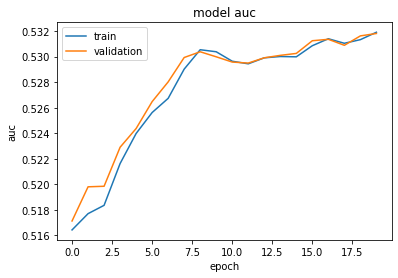

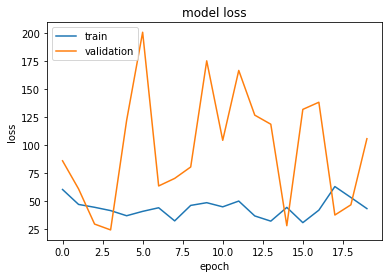

In [0]:
plt.plot(historia1.history['auc'])
plt.plot(historia1.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historia1.history['loss'])
plt.plot(historia1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 2. Red Neuronal Convolucional creada

In [0]:
# Estructuramos el DataAugmentacion para el train, validation y test

# Generador Data Augmentacion en Train 
train_datagen = ImageDataGenerator(
    rescale=1. / 127.5 - 1,#,                                    # 
    horizontal_flip=True,                                        #
    rotation_range=90,                                           # Rotaciónn de la imagen en el rango [0,90]
    brightness_range=[0.2,0.8],                                  #
    zoom_range=[0.8,1.2])                                        # Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                              # Directorio de datos de entrenamiento  
    target_size=(img_width, img_height),                         # Dimensiones de las imagenes    
    batch_size=batch_size,                                       # Particiones por imagenes                        
    class_mode='binary')                                         # Tipo de clase de labels

# Lectura de validation

validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 

validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, 
    class_mode='binary') 

# Lectura de test
test_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height), 
    batch_size=batch_size, shuffle = False,
    class_mode='binary') 

Found 8008 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [0]:
# Construcción de la red neuronal convolucional 
K.clear_session()
model_2 = Sequential()                                                               #
model_2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))        # Conv2D: Operacion de convolucion
model_2.add(MaxPooling2D((2, 2)))                                                    # Maxpooling: Operacion para reducir la dimension de las variables de entrada
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))                                                    # Maxpooling: Operacion para reducir la dimension de las variables de entrada
model_2.add(Conv2D(32, (3, 3), activation='relu')) 
model_2.add(MaxPooling2D((2, 2)))                                                    # Maxpooling: Operacion para reducir la dimension de las variables de entrada
model_2.add(Conv2D(16, (3, 3), activation='relu'))                                    #
model_2.add(MaxPooling2D((2, 2)))                                                    #
model_2.add(Conv2D(8, (3, 3), activation='relu'))                                   #

model_2.add(Flatten())                                                               # Flatten: Pasar todo a una dimension
model_2.add(Dense(64))                                                               # 
model_2.add(Activation('relu'))                                                      # 
model_2.add(Dropout(0.5))                                                            # 
model_2.add(Dense(1))                                                                # 
model_2.add(Activation('sigmoid'))                                                   #

model_2.summary()                                                                    # Mirar arquitectura del modelo

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)       

In [0]:
# Compilacion y ejecución

model_2.compile(loss='binary_crossentropy',       # Funcion de perdida                          
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),                # Optimizador de la red rmsprop
              metrics=[tf.keras.metrics.AUC()])   # Metrica a utilizar 
          

historia2 = model_2.fit_generator(
        train_generator,                        
        steps_per_epoch=nb_train_samples//batch_size,                    
        epochs=80,                                 
        validation_data=validation_generator)  
     

Epoch 1/80
125/125 [==============================] - 90s 721ms/step - loss: 0.8356 - auc: 0.4925 - val_loss: 0.6818 - val_auc: 0.4947
Epoch 2/80
125/125 [==============================] - 77s 616ms/step - loss: 0.7004 - auc: 0.5078 - val_loss: 0.6876 - val_auc: 0.5171
Epoch 3/80
125/125 [==============================] - 85s 680ms/step - loss: 0.6828 - auc: 0.5259 - val_loss: 0.6711 - val_auc: 0.5375
Epoch 4/80
125/125 [==============================] - 77s 616ms/step - loss: 0.6759 - auc: 0.5431 - val_loss: 0.5980 - val_auc: 0.5491
Epoch 5/80
125/125 [==============================] - 85s 681ms/step - loss: 0.6753 - auc: 0.5553 - val_loss: 0.5812 - val_auc: 0.5581
Epoch 6/80
125/125 [==============================] - 77s 616ms/step - loss: 0.6793 - auc: 0.5602 - val_loss: 0.7405 - val_auc: 0.5629
Epoch 7/80
125/125 [==============================] - 84s 673ms/step - loss: 0.6646 - auc: 0.5661 - val_loss: 0.5282 - val_auc: 0.5703
Epoch 8/80
125/125 [==============================] - 8

In [0]:
model_2.evaluate_generator(test_generator)

[0.3908633887767792, 0.7780877947807312]

In [0]:
# Guardo el modelo
model_2.save("modelo_2_CNN.h5")
model_2.save_weights("modelo_2_CNN_pesos")

### Graficas de desempeño

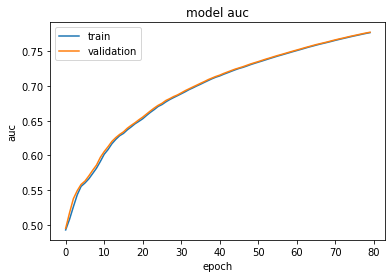

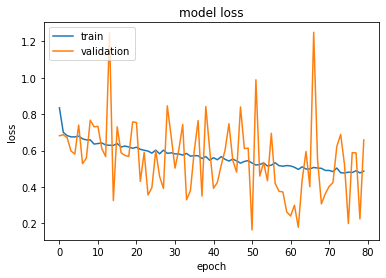

In [0]:
plt.plot(historia2.history['auc'])
plt.plot(historia2.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historia2.history['loss'])
plt.plot(historia2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 3. Red Neuronal Convolucional Pre-Entrenada (ResNet50)

In [0]:
# Estructuramos el DataAugmentacion para el train, validation y test

# Generador Data Augmentacion en Train 
train_datagen = ImageDataGenerator(
    rescale=1. / 127.5 - 1,                                      # 
    horizontal_flip=True,                                        #
    rotation_range=90,                                           # Rotaciónn de la imagen en el rango [0,90]
    brightness_range=[0.2,0.8],                                  #
    zoom_range=[0.8,1.2])                                        # Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                              # Directorio de datos de entrenamiento  
    target_size=(img_width, img_height),                         # Dimensiones de las imagenes    
    batch_size=batch_size,                                       # Particiones por imagenes
    shuffle = False,                                                               
    class_mode='binary')                                         # Tipo de clase de labels

# Lectura de validation

validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 

validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, shuffle = False,
    class_mode='binary') 

# Lectura de test
test_datagen = ImageDataGenerator(rescale= 1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height), 
    batch_size=2, shuffle = False,
    class_mode='binary') 

Found 8008 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [0]:
import tensorflow as tf
K.clear_session()
# Instacia del modelo y configuración
base_model = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', 
                                            include_top=False,              # False es para que yo ponga la salida
                                            input_shape= (256,256,3))

x = base_model.output                                               # salida de resnet
x = tf.keras.layers.GlobalAveragePooling2D()(x)                     # operacion de pooling
x = tf.keras.layers.Dropout(0.5)(x)                                 # regularizar

predictions = tf.keras.layers.Dense(1,                              # numero de clases
                    activation= 'sigmoid')(x)
# 
model_3 = tf.keras.models.Model(inputs = base_model.input, 
                              outputs = predictions)



model_3.compile(loss='binary_crossentropy',                                       # Funcion de perdida -> si es categorical, organizar el data_generator
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),         # Optimizar los pesos de la red
                metrics=[tf.keras.metrics.AUC()])                                 # Metrica AUC para desempeño 
                           


model_3.summary()                                                  # Mirar arquitectura del modelo resnet50

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [0]:
# Entrenamiento
historia3 = model_3.fit_generator(train_generator,                              # Data de entrenamiento 
                                  epochs=80,                            # Cuantas veces va a pasar por el dataset (100 podría ser un numero)
                                  validation_data=validation_generator,       # Data de validacion
                                  #steps_per_epoch=nb_train_samples/batch_size,                         # Particiones para entrenar n_samples/batch_size
                                  #batch_size=8,           # Imagenes por paso
                                  verbose=1,
                                  workers=1,
                                  use_multiprocessing = False)#,
                                  #validation_steps= 54/batch_size)                                  # Mostar los logs de entrenamiento

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
251/251 [==============================] - 6800s 27s/step - loss: 0.2752 - auc: 0.9523 - val_loss: 0.7384 - val_auc: 0.7944
Epoch 2/80
251/251 [==============================] - 269s 1s/step - loss: 0.0675 - auc: 0.9960 - val_loss: 1.1052 - val_auc: 0.6250
Epoch 3/80
251/251 [==============================] - 271s 1s/step - loss: 0.0122 - auc: 0.9997 - val_loss: 0.7016 - val_auc: 0.7263
Epoch 4/80
251/251 [==============================] - 270s 1s/step - loss: 0.0048 - auc: 1.0000 - val_loss: 1.0501 - val_auc: 0.6078
Epoch 5/80
251/251 [==============================] - 268s 1s/step - loss: 0.0021 - auc: 1.0000 - val_loss: 0.6365 - val_auc: 0.7941
Epoch 6/80
251/251 [==============================] - 267s 1s/step - loss: 0.0033 - auc: 1.0000 - val_loss: 0.4649 - val_auc: 0.9068
Epoch 7/80
251/251 [==============================] - 267s 1s/step - loss: 0.0334 - auc: 0.9971 - val_loss: 0.9792 - val_auc

In [0]:
model_3.evaluate_generator(test_generator ) 

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.5421354174613953, 0.9270381331443787]

In [0]:
#y_preds = model_1.predict_generator(test_generator,  verbose=1)

In [0]:
# Guardo el modelo
#model_3.save("modelo_3_Resnet50_vf_80.h5")

### Graficas de desempeño

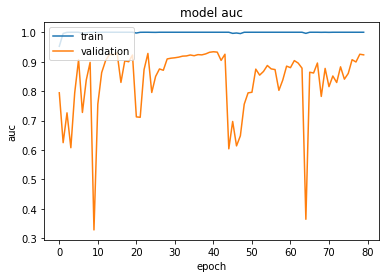

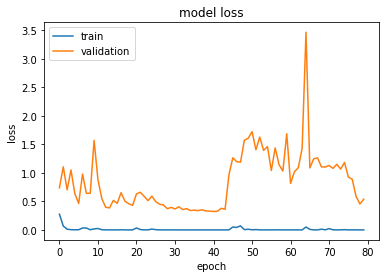

In [0]:
plt.plot(historia3.history['auc'])
plt.plot(historia3.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historia3.history['loss'])
plt.plot(historia3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()